In [ ]:
#environment related settings that would be used
#throughtout the project

!pip install selenium
# !apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

from bs4 import BeautifulSoup
from typing import Tuple
from time import sleep
import requests
import pandas as pd
import traceback

headers = {'User-Agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2) AppleWebKit/601.3.9 (KHTML, like Gecko) Version/9.0.2 Safari/601.3.9'}

In [88]:
from __future__ import division
from selenium import webdriver
from selenium.webdriver.common.by import By

#This section contains few helper that are used in different sections below

# utility function for re-scaling data
def rescale_values(values, req_min = 1, req_max = 10):
    rescaled = {}
    prev_min, prev_max = min(values), max(values)

    for v in values:
        rescaled_value = (req_max - req_min) / (prev_max - prev_min) * (v - prev_min) + req_min
        rescaled[str(v)] = rescaled_value

    return rescaled

def convert(x,a=1,b=5,c=1,d=10):
    """converts values in the range [a,b] to values in the range [c,d]"""
    v = c + float(x-a)*float(d-c)/(b-a)
    return round(v, 2)

def scroll_fetch_data(url):
  if url is None:
    return;
  # Headless/incognito Chrome driver  
  chrome_options = webdriver.ChromeOptions()
  chrome_options.add_argument('--headless')
  chrome_options.add_argument('--no-sandbox')
  chrome_options.add_argument('--disable-dev-shm-usage')
  chrome = webdriver.Chrome('chromedriver',options=chrome_options)
  
  chrome.get(url)

  # Set sleep time for the page to load on scroll
  SCROLL_PAUSE_TIME = 2

  # Get scroll height
  last_height = chrome.execute_script("return document.body.scrollHeight")

  # If you want to limit the number of scroll loads, add a limit here
  scroll_limit = 5

  count = 0
  while True and count < scroll_limit:
      # Scroll down to bottom
      chrome.execute_script("window.scrollTo(0, document.body.scrollHeight);")

      # Wait to load page
      sleep(SCROLL_PAUSE_TIME)

      # Calculate new scroll height and compare with last scroll height
      new_height = chrome.execute_script("return document.body.scrollHeight")
      if new_height == last_height:
          break
      last_height = new_height
      count += 1

  sleep(2) 

  return chrome.page_source

#this method is not used but tried with selenium scrolling and clicking element
def click_fetch_data(url):
  if url is None:
    return;
  
  # Headless/incognito Chrome driver  
  chrome_options = webdriver.ChromeOptions()
  chrome_options.add_argument('--headless')
  chrome_options.add_argument('--no-sandbox')
  chrome_options.add_argument('--disable-dev-shm-usage')
  chrome = webdriver.Chrome('chromedriver',options=chrome_options)
  
  chrome.get(url)

  # Set sleep time for the page to load on scroll
  SCROLL_PAUSE_TIME = 2

  # Get scroll height
  last_height = chrome.execute_script("return document.body.scrollHeight")

  # If you want to limit the number of scroll loads, add a limit here
  scroll_limit = 5

  count = 0
  while True and count < scroll_limit:
      # Scroll down to bottom
      chrome.execute_script("window.scrollTo(0, document.body.scrollHeight);")

      # Wait to load page
      sleep(SCROLL_PAUSE_TIME)

      # Calculate new scroll height and compare with last scroll height
      new_height = chrome.execute_script("return document.body.scrollHeight")
      if new_height == last_height:
          break
      last_height = new_height
      count += 1

  sleep(2) 

  chrome.find_element(By.CSS_SELECTOR, 'button.uitk-button-secondary').click()
  sleep(3) 

  return chrome.page_source


{'1': 1.0, '2': 3.25, '3': 5.5, '4': 7.75, '5': 10.0}
6.62


In [10]:
# This is the main method that send HTTP GET to booking.com
# And Fetch the listing page first. As the listing becomes available
# I get the hotel detail page URL and send another HTTP GET to fetch
# hotel details that are not available on the listing page e.g. images

def parse_booking_hotels(url):
  hotels_data = []
  response = requests.get(url,headers=headers)
  soup = BeautifulSoup(response.content,'lxml')

  for item in soup.select('div.a826ba81c4'):
    try:
      # hoten name
      hotel_name = item.select('.e13098a59f .a23c043802')
      if len(hotel_name) > 0:
        hotel_name = hotel_name[0].get_text().strip()
      # distance from city center
      hotel_distance_city_centre = item.select('.b978843432 .a1fbd102d9')
      if len(hotel_distance_city_centre) > 0:
        hotel_distance_city_centre = item.select('.b978843432 .a1fbd102d9')[0].contents[1].select('.cb5ebe3ffb')[0].get_text()
        hotel_distance_city_centre = hotel_distance_city_centre.split()[0]
      else:
        hotel_distance_city_centre = -1
      # Get review score
      hotel_review_score = item.select('.b978843432 .d10a6220b4')
      if len(hotel_review_score) > 0:
        hotel_review_score = item.select('.b978843432 .d10a6220b4')[0].get_text().strip()
      else:
        hotel_review_score = -1
      # Get star rating
      hotel_star_rating = len(item.select('.b978843432 .fbb11b26f5 span'))
      # Get Price
      hotel_price_per_night = item.select('.b978843432 .bd73d13072')
      if len(hotel_price_per_night) > 0:
        hotel_price_per_night = hotel_price_per_night[0].get_text().strip().split('$')
        hotel_price_per_night = hotel_price_per_night[1]
      # Get hotel page link
      hotel_page_link = item.select('.e13098a59f')[0].get('href')
      # Request hotel detail page, Get hotel address, desc, images
      hotel_page = requests.get(hotel_page_link,headers=headers)
      hotel_page_document = BeautifulSoup(hotel_page.content,'lxml')
      # Address
      hotel_address = hotel_page_document.select('.hp_address_subtitle')[0].get_text().strip()
      # description
      hotel_description = hotel_page_document.select('#property_description_content')[0].get_text()
      # images
      image_list = []
      hotel_image_wrappers = hotel_page_document.select('.bh-photo-grid-item')
      for image_wrapper in hotel_image_wrappers:
        # check it has an attribute then get the value only for 5 thumbnails
        if len(image_list) < 5 and image_wrapper.has_attr('data-thumb-url'):
          image_url = image_wrapper.get('data-thumb-url')
          image_list.append(image_url)
        elif len(image_list) < 5 and image_wrapper.has_attr('data-preview-image-layout'):
          image_url = image_wrapper.select('img')[0].get('src')
          image_list.append(image_url)
    except Exception as e:
      print('something went wrong while parsing hotel data from booking.com')
    hotels_data.append([hotel_name,hotel_distance_city_centre,hotel_review_score,hotel_star_rating,hotel_price_per_night,hotel_address,hotel_description,image_list,'booking.com'])
  return hotels_data

# To keep it simple I am doing this in two steps. One batch size is 25
first_twenty_five_hotels_url = 'https://www.booking.com/searchresults.en-gb.html?ss=Frankfurt%2FMain&ssne=Frankfurt%2FMain&ssne_untouched=Frankfurt%2FMain&label=gen173nr-1FCAEoggI46AdIM1gEaEiIAQGYAQm4ARnIAQzYAQHoAQH4AQuIAgGoAgO4ApWjt5kGwAIB0gIkYjVhZmFhOWEtMmUzNS00MjkxLWFmMmEtOWU3YWZkZjQzOWQy2AIG4AIB&sid=e69c178aaa206bd748cc67505f49cc65&aid=304142&lang=en-gb&sb=1&src_elem=sb&src=searchresults&dest_id=-1771148&dest_type=city&checkin=2022-10-05&checkout=2022-10-06&group_adults=1&no_rooms=1&group_children=0&sb_travel_purpose=leisure'
next_twenty_five_hotels_url = 'https://www.booking.com/searchresults.en-gb.html?ss=Frankfurt%2FMain&ssne=Frankfurt%2FMain&ssne_untouched=Frankfurt%2FMain&label=gen173nr-1FCAEoggI46AdIM1gEaEiIAQGYAQm4ARnIAQzYAQHoAQH4AQuIAgGoAgO4ApWjt5kGwAIB0gIkYjVhZmFhOWEtMmUzNS00MjkxLWFmMmEtOWU3YWZkZjQzOWQy2AIG4AIB&sid=e69c178aaa206bd748cc67505f49cc65&aid=304142&lang=en-gb&sb=1&src_elem=sb&src=searchresults&dest_id=-1771148&dest_type=city&checkin=2022-10-05&checkout=2022-10-06&group_adults=1&no_rooms=1&group_children=0&sb_travel_purpose=leisure&offset=25'

# Get 50 Hotels from booking.com
booking_hotels_data = parse_booking_hotels(first_twenty_five_hotels_url) + parse_booking_hotels(next_twenty_five_hotels_url)

[['Trip Inn Residence City Center', '0.8', '7.7', 4, '140', 'Oskar-von-Miller-Straße 14, Ostend, 60314 Frankfurt/Main, Germany', "\n\nYou're eligible for a Genius discount at Trip Inn Residence City Center! To save at this property, all you have to do is sign in.\nTrip Inn Residence City Center is situated directly on the River Main in Frankfurt, 650 feet from the Sachsenhausen Old Town district and 1,000 feet from the European Central Bank.\nThe Trip Inn Residence City Center offers modern rooms, suites and apartments. WiFi is provided free of charge. \n", ['https://cf.bstatic.com/xdata/images/hotel/max500/188934707.jpg?k=9e6a1fe3cdf7cad40afe7b1a7bacedc65252cc6a7c28b3ece8956a28857c05c0&o=&hp=1', 'https://cf.bstatic.com/xdata/images/hotel/max500/187065163.jpg?k=f81a6edb7070a8241086663c9b6441ebe8db30ac2efb7bdd821c41db916e92a6&o=&hp=1', 'https://cf.bstatic.com/xdata/images/hotel/max500/209098279.jpg?k=d69dbb7d96acfe0daa996e3451059057cba2849ea90ad75a8a5090b1cea52899&o=&hp=1', 'https://cf.

In [11]:
#save booking hotels in a seperate CSV file for testing and validation
booking_hotels = pd.DataFrame(booking_hotels_data, columns=['Name', 'Distance From City Center(miles)', 'Review Score', 'Star Rating', 'Price Per Night (USD)', 'Address', 'Description', 'Images', 'Source'])
# save booking data to csv
booking_hotels.to_csv('booking_hotels.csv', index=False)

In [77]:
# This is the main method that send HTTP GET to hotels.com
# And Fetch the listing page first. As the listing becomes available
# I get the hotel detail page URL and send another HTTP GET to fetch
# hotel details that are not available on the listing page e.g. images

def parse_hotel_com_hotels(url):
  hotels_data = []
  response = requests.get(url,headers=headers)
  soup = BeautifulSoup(response.content,'lxml')
  
  for item in soup.select('li.uitk-spacing-margin-blockstart-three'):
    if item.has_attr('data-stid'):
      continue
    try:
      # Get Price
      hotel_price_per_night = item.select('.uitk-card-content-section')
      if len(hotel_price_per_night) > 0:
        hotel_price_per_night = hotel_price_per_night[0].select('.uitk-text.uitk-type-600.uitk-type-bold.uitk-text-emphasis-theme')[0].get_text().strip().lstrip('$')
      # hoten page link
      hotel_page_link = 'https://www.hotels.com/' + item.select('.uitk-card-link')[0].get('href')
      hotel_page = requests.get(hotel_page_link, headers=headers)
      # hotel: detail page markup|document
      hotel = BeautifulSoup(hotel_page.content,'lxml')
      hotel_main_tab = hotel.select('.uitk-card-content-section.uitk-card-content-section-padded.uitk-card.uitk-card-roundcorner-all.uitk-spacing.uitk-flat-border-top')[0]
      # get hotel name
      hotel_name = hotel_main_tab.select('.uitk-heading-3')[0].get_text().strip()
      #distance from city centre
      hotel_distance_city_centre = item.select('.uitk-text.uitk-text-spacing-half.truncate-lines-2.uitk-type-300.uitk-text-default-theme')
      if len(hotel_distance_city_centre) > 0:
        hotel_distance_city_centre = hotel_distance_city_centre[0].get_text().split()[0]
      else:
        hotel_distance_city_centre = -1
      # Get review score
      hotel_review_score = hotel_main_tab.select('.uitk-spacing.uitk-spacing-padding-blockend-six')
      if len(hotel_review_score) > 0:
        hotel_review_score = hotel_review_score[0].select('meta')
        if len(hotel_review_score) > 0:
          hotel_review_score = hotel_review_score[0].get('content')
        else:
          hotel_review_score = -1
      else:
        hotel_review_score = -1
      # Get star rating
      hotel_star_rating = hotel_main_tab.select('.uitk-spacing.uitk-spacing-padding-small-blockend-four.uitk-spacing-padding-large-blockstart-three')
      if len(hotel_star_rating) > 0:
        hotel_star_rating = hotel_star_rating[0].select('.uitk-rating .is-visually-hidden')
        if len(hotel_star_rating) > 0:
          hotel_star_rating = hotel_star_rating[0].get_text().split()[0]
        else:
          hotel_star_rating = -1
      else:
        hotel_star_rating = -1
      # Address
      hotel_address = hotel_main_tab.select('.uitk-text.uitk-type-300.uitk-text-default-theme.uitk-layout-flex-item')[0].get_text().strip()
      # description
      hotel_description = hotel_main_tab.select('.uitk-text.uitk-type-300.uitk-text-default-theme')[0].get_text().strip()
      # images
      image_list = []
      hotel_images = hotel.select('#Overview img.uitk-image-media')
      for hotel_image in hotel_images:
        if len(image_list) < 5:
          image_url = hotel_image.get('src')
          image_list.append(image_url)    
    except Exception as e:
      print(traceback.format_exc())
    hotels_data.append([hotel_name,hotel_distance_city_centre,hotel_review_score,hotel_star_rating,hotel_price_per_night,hotel_address,hotel_description,image_list, 'hotels.com'])
  return hotels_data

# Get 50 hotels from hotels.com
hotels_url = "https://www.hotels.com/Hotel-Search?adults=1&d1=2022-10-06&d2=2022-10-07&destination=Frankfurt%2C%20Hessen%2C%20Germany&directFlights=false&endDate=2022-10-06&hotels-destination=Frankfurt%2C%20Hessen%2C%20Germany&l10n=%5Bobject%20Object%5D&latLong=50.110924%2C8.682127&localDateFormat=M%2Fd%2Fyyyy&partialStay=false&regionId=1246&semdtl=&sort=DISTANCE&startDate=2022-10-05&theme=&useRewards=false"
hotel_com_hotels_data = parse_hotel_com_hotels(hotels_url)


[['Hotel Miramar am Römer', '0.07', '8.2', '3.0', '170', 'Berliner Straße 31, Frankfurt, HE, 60311', '3-star hotel with bar/lounge, near Romerberg', ['https://images.trvl-media.com/hotels/1000000/210000/201200/201186/935680e1.jpg?impolicy=resizecrop&rw=598&ra=fit', 'https://images.trvl-media.com/hotels/1000000/210000/201200/201186/18748e3d.jpg?impolicy=resizecrop&rw=297&ra=fit', 'https://images.trvl-media.com/hotels/1000000/210000/201200/201186/7db0236b.jpg?impolicy=resizecrop&rw=297&ra=fit', 'https://images.trvl-media.com/hotels/1000000/210000/201200/201186/b2475161.jpg?impolicy=resizecrop&rw=297&ra=fit', 'https://images.trvl-media.com/hotels/1000000/210000/201200/201186/17309c26.jpg?impolicy=resizecrop&rw=297&ra=fit'], 'hotels.com'], ['Motel One Frankfurt - Römer', '0.19', '9.0', -1, '225', 'Berliner Straße 55, Frankfurt, 60311', 'Hotel with bar/lounge, near Frankfurt Trade Fair', ['https://images.trvl-media.com/hotels/27000000/26600000/26590700/26590630/215e8e2c.jpg?impolicy=resizec

In [78]:
#save hotels.com hotels in a seperate CSV file for testing and validation
hotel_com_hotels = pd.DataFrame(hotel_com_hotels_data, columns=['Name', 'Distance From City Center(miles)', 'Review Score', 'Star Rating', 'Price Per Night (USD)', 'Address', 'Description', 'Images', 'Source'])
# save hotels.com data to csv
hotel_com_hotels.to_csv('hotel_com_hotels.csv', index=False)

In [86]:
# This is the main method that send HTTP GET to travelocity.com
# And Fetch the listing page first. As the listing becomes available
# I get the hotel detail page URL and send another HTTP GET to fetch
# hotel details that are not available on the listing page e.g. images

def parse_travelocity_hotels(url):
  hotels_data = []
  #execute scroll using selenium so that all hotels becomes available
  #within DOM and then fetch them and hands over the markup to BeautifulSoup
  #for parsing
  all_hotels_markup = scroll_fetch_data(url)
  soup = BeautifulSoup(all_hotels_markup,'lxml')
  
  # Get star rating
  hotel_star_rating = -1
  
  for item in soup.select('li.uitk-spacing-margin-blockstart-three'):
    if item.has_attr('data-stid'):
      continue
    try:
      # Get Price
      hotel_price_per_night = item.select('.uitk-text.uitk-type-600.uitk-type-bold.uitk-text-emphasis-theme')
      if len(hotel_price_per_night) > 0:
        hotel_price_per_night = hotel_price_per_night[0].get_text().strip().lstrip('$')
      # hoten page link
      hotel_page_link = 'https://www.travelocity.com/' + item.select('.uitk-card-link')[0].get('href')
      hotel_page = requests.get(hotel_page_link, headers=headers)
      # hotel: detail page markup|document
      hotel = BeautifulSoup(hotel_page.content,'lxml')
      hotel_main_tab = hotel.select('.uitk-card-content-section.uitk-card-content-section-padded.uitk-card.uitk-card-roundcorner-all.uitk-spacing.uitk-flat-border-top')[0]
      # get hotel name
      hotel_name = hotel_main_tab.select('.uitk-heading-3')
      if len(hotel_name) > 0:
        hotel_name = hotel_name[0].get_text().strip()
      #distance from city centre
      hotel_distance_city_centre = item.select('.uitk-text.uitk-text-spacing-half.truncate-lines-2.uitk-type-300.uitk-text-default-theme')
      if len(hotel_distance_city_centre) > 0:
        hotel_distance_city_centre = hotel_distance_city_centre[0].get_text().strip().split()[0]
      else:
        hotel_distance_city_centre = -1
      # Get review score
      hotel_review_score = hotel_main_tab.select('.uitk-spacing.uitk-spacing-padding-blockend-six')
      if len(hotel_review_score) > 0:
        # I re-scaled the data from 1-5 to 1-10
        meta_tag = hotel_review_score[0].select('meta')
        if len(meta_tag) > 0:
          hotel_review_score = convert(float(meta_tag[0].get('content')))
        else:
          hotel_review_score = -1
      else:
        hotel_review_score = -1
      # Address
      hotel_address = hotel_main_tab.select('.uitk-text.uitk-type-300.uitk-text-default-theme.uitk-layout-flex-item.uitk-layout-flex-item-flex-basis-full_width')
      if len(hotel_address) > 0:
        hotel_address = hotel_address[0].get_text().strip()
      # description
      hotel_description = hotel_main_tab.select('.uitk-subheading')
      if(len(hotel_description) > 0):
        hotel_description = hotel_description[0].get_text().strip()
      # images
      image_list = []
      hotel_images = hotel.select('#Overview img.uitk-image-media')
      for hotel_image in hotel_images:
        if len(image_list) < 5:
          image_url = hotel_image.get('src')
          image_list.append(image_url) 
    except Exception as e:
      print('something went wrong while parsing hotel data from travelocity.com')
    hotels_data.append([hotel_name,hotel_distance_city_centre,hotel_review_score,hotel_star_rating,hotel_price_per_night,hotel_address,hotel_description,image_list,'travelocity.com'])
  return hotels_data

# Get 50 hotels from travelocity.com
travelocity_url = "https://www.travelocity.com/Hotel-Search?adults=1&d1=2022-10-05&d2=2022-10-06&destination=Frankfurt%20%28and%20vicinity%29%2C%20Hessen%2C%20Germany&directFlights=false&endDate=2022-10-06&l10n=%5Bobject%20Object%5D&latLong=50.108788%2C8.665647&localDateFormat=M%2Fd%2Fyyyy&partialStay=false&regionId=179894&semdtl=&sort=DISTANCE&startDate=2022-10-05&theme=&useRewards=false"
travelocity_hotels_data = parse_travelocity_hotels(travelocity_url)

In [87]:
#save travelocity hotels in a seperate CSV file for testing and validation
travelocity_hotels = pd.DataFrame(travelocity_hotels_data, columns=['Name', 'Distance From City Center(miles)', 'Review Score', 'Star Rating', 'Price Per Night (USD)', 'Address', 'Description', 'Images','Source'])
# save travelocity data to csv
travelocity_hotels.to_csv('travelocity_hotels.csv', index=False)

In [124]:
#merge all hotels from three different sources into one for EDA
all_hotels_data = booking_hotels_data + hotel_com_hotels_data + travelocity_hotels_data
data_set = pd.DataFrame(all_hotels_data, columns=['hotel-name', 'distance-frm-cc-miles', 'review-score', 'star-rating', 'price-usd', 'address', 'desc', 'images','data-source'])
# save data set to csv
data_set.to_csv('hotels_dataset.csv', index=False)

In [ ]:
#Import Libraries
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns #Understanding my variables

# read hotels dataset
df = pd.read_csv('hotels_dataset.csv')
#Data cleanup for visualisation
df = df.replace(-1, np.NaN)

In [127]:
#data prepration for EDA, following method infer data types from data and replace them in place
#hence providing data that can be plotted using graph libraries like matplotlib or seaborn
df = df.infer_objects()

hotel-name                object
distance-frm-cc-miles    float64
review-score             float64
star-rating              float64
price-usd                  int64
address                   object
desc                      object
images                    object
data-source               object
dtype: object

In [139]:
# Descriptive Analysis; This gives an overall idea of how the data is distributed between 
#min, max and what are the mean and standard deviations so that We can validate the graphs 
#and find correaltion between features for more comprehensive EDA
df.describe().apply(lambda s: s.apply(lambda x: format(x, 'f')))

,distance-frm-cc-miles,review-score,star-rating,price-usd
count,120.000000,117.000000,67.000000,120.000000
mean,1.038083,7.796154,3.559701,251.666667
std,1.666750,0.888920,0.915036,104.267943
min,0.010000,4.375000,0.000000,21.000000
25%,0.190000,7.300000,3.000000,180.000000
50%,0.365000,8.000000,4.000000,244.000000
75%,0.900000,8.400000,4.000000,294.750000
max,7.100000,9.200000,5.000000,620.000000


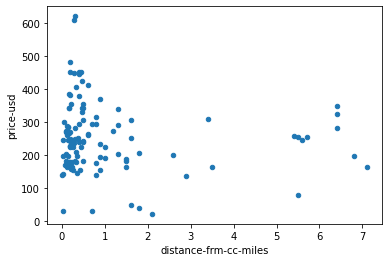

In [140]:
#This shows correlation between distance from center and price per night
#If the hotel is closer to city center prices tend to be around and above $200
#goes to $500 though there are very few options but hotels that are far away from city centre
#has prices less than 300 USD
df.plot(kind='scatter', x='distance-frm-cc-miles', y='price-usd')

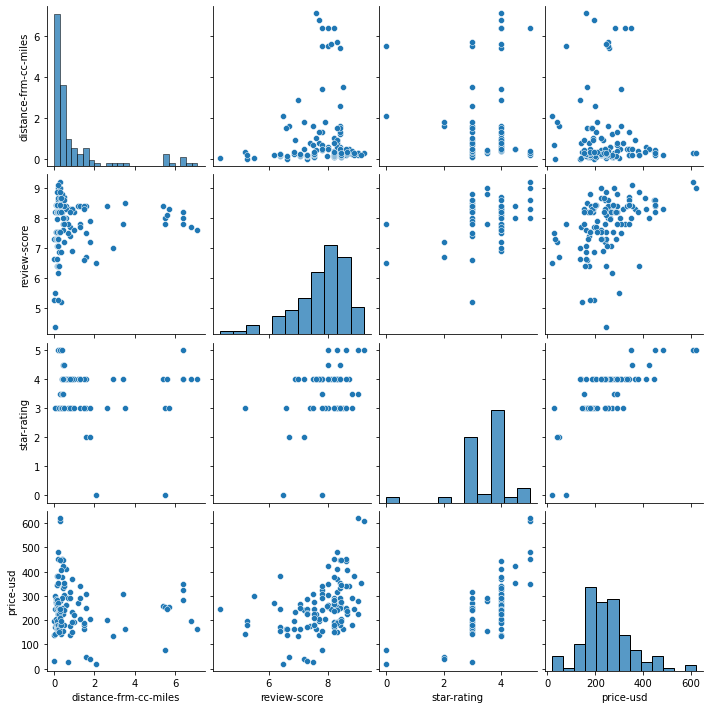

In [141]:
#This comprehensive relation between major factors 
#a person takes into consideration while choosing a hotel
#like distance from city centre, reviews score, five star rating 
#and correspoding price 
sns.pairplot(df)

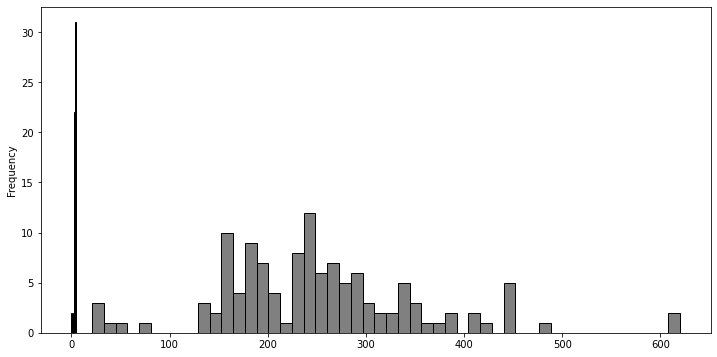

In [144]:
df['price-usd'].plot(kind='hist', bins=50, figsize=(12,6), facecolor='grey',edgecolor='black')

In [146]:
df['star-rating'].describe()

count    67.000000
mean      3.559701
std       0.915036
min       0.000000
25%       3.000000
50%       4.000000
75%       4.000000
max       5.000000
Name: star-rating, dtype: float64

In [147]:
df['star-rating'].value_counts()

4.0    31
3.0    22
5.0     5
3.5     3
2.0     2
0.0     2
4.5     2
Name: star-rating, dtype: int64

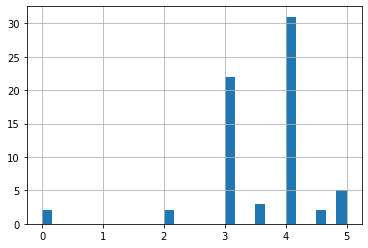

In [150]:
df['star-rating'].hist(bins=30)

In [151]:
#Lets get started with UI
!pip install ipywidgets 
# To enable `ipywidgets`
!jupyter nbextension enable --py widgetsnbextension

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 8.9 MB/s 
Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [182]:
from ipywidgets import widgets
from IPython.core.display import HTML

#Get widgets ready for user input
price_slider = widgets.IntRangeSlider(value=[0,df['price-usd'].max()], min=0, max=df['price-usd'].max())
distance_slider = widgets.IntRangeSlider(value=[0,df['distance-frm-cc-miles'].max()], min=0, max=df['distance-frm-cc-miles'].max())
review_slider = widgets.IntRangeSlider(value=[0,df['review-score'].max()], min=0, max=df['review-score'].max())
rating_dropdown = widgets.Dropdown(
    options=[('Select Rating', 0), ('One Star', 1), ('Two Star', 2), ('Three Star', 3), ('Four Star', 4), ('Five Star', 5)],
    value=1,
    description='Number:'
)
sorting_dropdown = widgets.Dropdown(
    options=[('By price', 'price-usd'), ('By Distance', 'distance-frm-cc-miles'), ('By Review Score', 'review-score'), ('By Rating', 'star-rating')],
    value='price-usd',
)
search_hotel_name =  widgets.Text(
    placeholder='Enter hotel name',
)

#helper function for image rendering
def path_to_image_html(paths: list) -> str:
  all_images = ''
  paths = paths.strip('[,]').split(',')
  for path in paths:
    all_images += '<img src="'+ path.strip('" ",\'') + '" width="60" >'
  return all_images

#Filter hotels data according to the user input
#this function also implements a decorator using interact that provides
#the following function as a callback for receiving user input values
def filter_hotels(all_hotels): 
  @widgets.interact(price_range=price_slider, distance_cc=distance_slider, review_score=review_slider, rating=rating_dropdown, sort_order=sorting_dropdown, search_hotel=search_hotel_name)
  def price_filter(price_range, distance_cc, review_score, rating, sort_order, search_hotel):
    results = []
    filtered_df = all_hotels[(all_hotels['price-usd'] <= price_range[1]) & (all_hotels['price-usd'] >= price_range[0])]
    filtered_df = filtered_df[(filtered_df['distance-frm-cc-miles'] <= distance_cc[1]) & (filtered_df['distance-frm-cc-miles'] >= distance_cc[0])]
    filtered_df = filtered_df[(filtered_df['review-score'] <= review_score[1]) & (filtered_df['review-score'] >= review_score[0])]
    if(rating > 0):
      filtered_df = filtered_df[(filtered_df['star-rating'] >= rating)]
    if( len(search_hotel) > 0):
      filtered_df = filtered_df[(filtered_df['hotel-name'].str.contains(search_hotel, regex=False, case=False))]
    
    results = filtered_df.sort_values(by=sort_order, ascending=True)
    results['desc'] = results['desc'].str.slice(0,25)
    return HTML(results.to_html(escape=False,formatters=dict(images=path_to_image_html)))

filter_hotels(df)

interactive(children=(IntRangeSlider(value=(0, 620), description='price_range', max=620), IntRangeSlider(value…